#### Exercise 1. Iris

sử dụng PCA để giảm số chiều, vẽ hình trực quan hóa dữ liệu

In [2]:
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

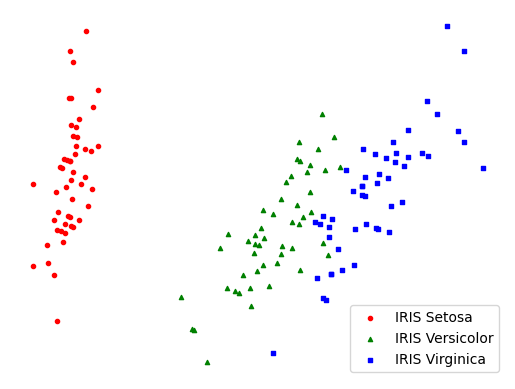

In [3]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :4] # we take full 4 features
Y = iris.target

# Normalize data
X_norm = (X - X.min())/(X.max() - X.min())

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))

# visualize
plt.axis("off")
plt.scatter(transformed[Y==0][0], transformed[Y==0][1], s=9, label='IRIS Setosa',
c='red')
plt.scatter(transformed[Y==1][0], transformed[Y==1][1], s=9, label='IRIS Versicolor',
c='green', marker="^")
plt.scatter(transformed[Y==2][0], transformed[Y==2][1], s=9, label='IRIS Virginica',
c='blue', marker="s")
plt.legend()
plt.show()

##### (a) tự xây dựng các hàm từ numpy

In [4]:
# split data into training:validation set with proportion of 4:1, in which
# each class has the same number of observations in training set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=17, stratify=Y)
print(X_train.shape)
print(X_train[Y_train == 0].shape)

(120, 4)
(40, 4)


In [5]:
from scipy import sparse

def convert_labels(y, C):
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), 
                          shape = (C, len(y))).toarray()
    return Y

In [6]:
def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_count:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count%check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

In [7]:
# print out result of prediction
eta = .05
d = X_train.shape[1]
C = 3
W_init = np.random.randn(d, C)
W_init
W = softmax_regression(X_train.T, Y_train.T, W_init, eta)
print(W[-1])

[[ 1.8958735   2.12130343 -4.55603973]
 [ 4.00809988  0.16902138 -4.8262953 ]
 [-6.18021904 -1.58121537  6.14644228]
 [-2.86591727 -4.59607042  5.09530935]]


In [8]:
def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

Z = pred(W[-1], X_test.T)
Z

array([1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2,
       1, 0, 0, 2, 2, 2, 0, 2], dtype=int64)

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

cm = confusion_matrix(Y_test, Z)
print(cm)

acc = accuracy_score(Y_test, Z)
prec = precision_score(Y_test, Z, average=None)
rec = recall_score(Y_test, Z, average=None)

print('Accuracy =', acc)
print('Precision = ', prec)
print('Recall = ', rec)

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
Accuracy = 0.9666666666666667
Precision =  [1.         0.90909091 1.        ]
Recall =  [1.  1.  0.9]


##### (b) sử dụng hàm từ thư viện scikit-learn

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data # Observed variable
Y = iris.target # Dependent variable (label)
print(X.shape)
print(Y.shape)

(150, 4)
(150,)


In [11]:
# split training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# call Logistic Regression Model - SAG: solving is based on Stochastic Average Gradient
lorg = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=5000)
# and train model by training set
lorg.fit(X_train,Y_train)

# make prediction on test set
Y_pred = lorg.predict(X_test)
Y_pred

array([0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 2, 1,
       2, 1, 1, 0, 0, 2, 0, 2])

In [12]:
# for accuracy
print('Accuracy:', accuracy_score(Y_test,Y_pred))
# for confusion matrix
cm = confusion_matrix(Y_test,Y_pred)
print(cm)

Accuracy: 0.9666666666666667
[[14  0  0]
 [ 0  7  1]
 [ 0  0  8]]


#### Exercise 2. 20NewsGroups

In [13]:
'''
dataset: 20NewsGroups contains 20,000 short pieces of news (text) divided into 
        20 categories that belong to 6 different groups, such as
        comp, rec, sci, míc, politics, religion.
problem: classify each piece of news into its category.
        the dataset is encoded using bag-of-words for solving this problem.
input: (vectorized) text
output: category
method: multinomial logistic regression
'''

'\ndataset: 20NewsGroups contains 20,000 short pieces of news (text) divided into \n        20 categories that belong to 6 different groups, such as\n        comp, rec, sci, míc, politics, religion.\nproblem: classify each piece of news into its category.\n        the dataset is encoded using bag-of-words for solving this problem.\ninput: (vectorized) text\noutput: category\nmethod: multinomial logistic regression\n'

In [14]:
# import library
from sklearn.datasets import fetch_20newsgroups_vectorized

# load dataset
n_samples = 1000

X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
X = X[:n_samples]
y = y[:n_samples]

In [15]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print('No. of training samples:', train_samples)
print('No. of features:', n_features)
print('No. of classes:', n_classes)

No. of training samples: 800
No. of features: 130107
No. of classes: 20


In [16]:
# call method
lorg = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=100)
# fit model
lorg.fit(X_train, y_train)
# predict
y_pred = lorg.predict(X_test)

In [17]:
# accuracy
accu = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.9666666666666667
[[ 6  0  1  0  0  0  0  0  0  1  0  0  0  1  0  1  0  0  0  0]
 [ 0  5  3  0  0  0  1  0  0  0  0  0  0  2  0  1  1  0  0  0]
 [ 0  2  5  0  0  0  2  0  0  0  0  0  1  1  0  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  1  0  1  1  0  2  0  0  0  0]
 [ 0  2  1  0  3  0  0  0  0  0  2  0  0  2  0  0  0  0  0  0]
 [ 0  3  2  0  0  2  0  0  0  0  2  0  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  8  0  0  0  0  0  0  2  0  1  0  0  0  0]
 [ 0  1  1  0  0  0  1  1  3  0  1  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  3  0  2  0  1  0  0  2  0  0  2  0  0  0]
 [ 0  1  1  0  0  0  0  0  0  4  2  0  0  1  0  0  0  1  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  2  5  0  1  0  0  0  0  0  0]
 [ 0  4  1  0  0  0  0  0  0  0  1  1  0  0  0  0  1  1  0  0]
 [ 0  0  1  0  0  0  1  1  0  0  1  0  0  7  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  1  0  0  1  6  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0 

#### Exercise 3. Glass Identification

In [18]:
'''
problem: identify different type of glasses based on chemical content 
dataset: 214 samples, identified by chemical cpntent, which are
         RI, Na, Mg, Al, Si, K, Ca, Ba, Fe
input: chemical content inside each glass sample
output: type of glass (6 types = 6 classes)
method: multinomial logistic regression
'''

'\nproblem: identify different type of glasses based on chemical content \ndataset: 214 samples, identified by chemical cpntent, which are\n         RI, Na, Mg, Al, Si, K, Ca, Ba, Fe\ninput: chemical content inside each glass sample\noutput: type of glass (6 types = 6 classes)\nmethod: multinomial logistic regression\n'

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# load dataset from file
file_data = 'glass.csv'
glass_df = pd.read_csv(file_data)
print(glass_df.info())

glass_types = glass_df['Type'].unique()
print(glass_types)

print(glass_df['Type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id_Number  214 non-null    int64  
 1   RI         214 non-null    float64
 2   Na         214 non-null    float64
 3   Mg         214 non-null    float64
 4   Al         214 non-null    float64
 5   Si         214 non-null    float64
 6   K          214 non-null    float64
 7   Ca         214 non-null    float64
 8   Ba         214 non-null    float64
 9   Fe         214 non-null    float64
 10  Type       214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB
None
[1 2 3 5 6 7]
Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64


In [3]:
# split data into training and test set
from sklearn.model_selection import train_test_split

X_1 = glass_df[glass_df.columns[:-1]]
y_1 = glass_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.25, random_state=42)

print('No. of training samples:', X_train.shape[0])
print('No. of features:', X_train.shape[1])
print('No. of classes:', len(glass_types))

No. of training samples: 160
No. of features: 10
No. of classes: 6


In [8]:
print(X_1.shape)
print(y_1.shape)

(214, 10)
(214,)


In [21]:
# call built-in method
lorg = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=5000)
# fit model
lorg.fit(X_train, y_train)
# predict using test set
y_pred = lorg.predict(X_test)
y_pred

array([1, 7, 1, 7, 2, 2, 1, 2, 2, 2, 6, 5, 2, 2, 6, 5, 7, 1, 1, 6, 2, 7,
       7, 7, 3, 2, 1, 1, 5, 1, 1, 2, 3, 2, 1, 7, 5, 3, 2, 2, 2, 7, 1, 2,
       3, 2, 2, 2, 2, 2, 1, 1, 1, 2], dtype=int64)

In [22]:
# accuracy score
accu = accuracy_score(y_test, y_pred)
print('Accuracy:', accu)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 1.0
[[14  0  0  0  0  0]
 [ 0 21  0  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  8]]


#### Exercise 4. Handwritten digits recognition

In [23]:
'''
problem: identify handwritten digits (0-9) from images
dataset: handwritten digits images have been encoded into 
        chains of bits representing pixels.
        training set - 60,000 samples
        test set - 10,000 samples
input: images of handwritten digits (pixels encoded)
output: predicted digit
method: multinomial logistic regression
'''

'\nproblem: identify handwritten digits (0-9) from images\ndataset: handwritten digits images have been encoded into \n        chains of bits representing pixels.\n        training set - 60,000 samples\n        test set - 10,000 samples\ninput: images of handwritten digits (pixels encoded)\noutput: predicted digit\nmethod: multinomial logistic regression\n'

##### (a) Tự xây dựng hàm từ numpy

In [24]:
# import library
import os
import numpy as np

# define paths
data_path = 'D:/python/pyforml/week04_multinomial-regression/homework'
# train path
train_img_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [25]:
# extract and read data from file
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    import gzip # to decompress gz (zip) file

    # read training data
    f_images = gzip.open(images_path,'r')

    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)

    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)

    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # convert into images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    # read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)

    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [26]:
# call read input method
train_images, train_labels = get_mnist_data(
    train_img_path, train_labels_path, 5000, shuffle=True)
test_images, test_labels = get_mnist_data(
    test_images_path, test_labels_path, 10000, _is=False, shuffle=True)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2440\1250645001.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)
(10000, 784) (10000,)


In [27]:
# no. of dimension: 28x28=784
# no. of classes: 10
# no. of samples used: 5000 

In [28]:
# convert matrix to image
def get_image(image):
    return image.reshape(28, 28)

# self-built method for solving this problem
def convert_labels(y, C):
    from scipy import sparse
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

In [29]:
def _softmax_regression(X, Y, theta, lambda_=0.5, iterations=20, 
                        learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss

    losses = []
    _theta = theta
    d, N = X.shape

    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losses.append(log_loss(Y, Y_hat))
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")
    
    return _theta, losses

1 8


<Figure size 640x480 with 0 Axes>

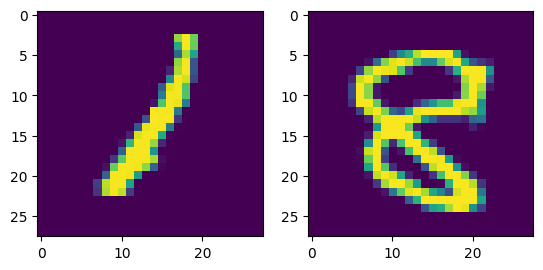

In [30]:
# for display and test digit
import random
import matplotlib.pyplot as plt

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])

train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

# use the created array to output your multiple images. 
# in this case we have stacked 2 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

In [32]:
# prepare training data
X_train = np.concatenate((np.ones((1, train_images.shape[0])), 
                          train_images.T), axis = 0)
Y_train = convert_labels(train_labels, 10)
print(X_train.shape)
print(Y_train.shape)

(785, 5000)
(10, 5000)


In [ ]:
# fit model and print out loss value
theta = np.zeros((X_train.shape[0], 10))
opt_theta, losses = _softmax_regression(X_train, Y_train, theta)
print('training success: ', opt_theta.shape, len(losses))

In [34]:
from sklearn.metrics import accuracy_score

print('accuracy training data: ', accuracy_score(train_labels, pred(opt_theta, X_train)))

accuracy training data:  0.9448


##### (b) Giảm chiều & trực quan hóa dữ liệu (PCA)

In [35]:
train_images.shape

(5000, 784)

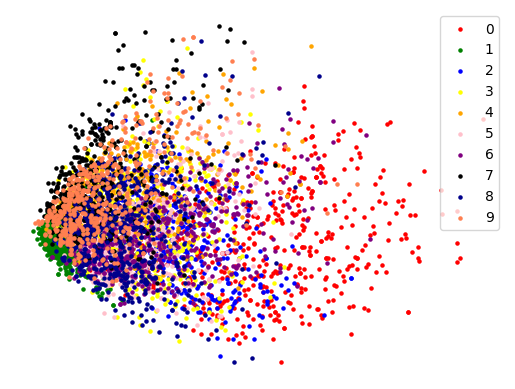

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaled_images = StandardScaler().fit_transform(train_images)
pca = PCA(n_components=2) # 2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(scaled_images))

# visualize
plt.axis("off")
plt.scatter(transformed[train_labels==0][0], transformed[train_labels==0][1], s=5, label='0', c='red')
plt.scatter(transformed[train_labels==1][0], transformed[train_labels==1][1], s=5, label='1', c='green')
plt.scatter(transformed[train_labels==2][0], transformed[train_labels==2][1], s=5, label='2', c='blue')
plt.scatter(transformed[train_labels==3][0], transformed[train_labels==3][1], s=5, label='3', c='yellow')
plt.scatter(transformed[train_labels==4][0], transformed[train_labels==4][1], s=5, label='4', c='orange')
plt.scatter(transformed[train_labels==5][0], transformed[train_labels==5][1], s=5, label='5', c='pink')
plt.scatter(transformed[train_labels==6][0], transformed[train_labels==6][1], s=5, label='6', c='purple')
plt.scatter(transformed[train_labels==7][0], transformed[train_labels==7][1], s=5, label='7', c='black')
plt.scatter(transformed[train_labels==8][0], transformed[train_labels==8][1], s=5, label='8', c='darkblue')
plt.scatter(transformed[train_labels==9][0], transformed[train_labels==9][1], s=5, label='9', c='coral')
plt.legend()
plt.show()

# giảm xuống 2 chiều không tách bạch được rõ các lớp của dataset

##### (c) sử dụng thư viện 

In [37]:
from sklearn.linear_model import LogisticRegression

# fit model
lorg = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=100)
lorg.fit(train_images, train_labels)

# predict
Y_pred = lorg.predict(test_images)

c:\Users\Admin\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [38]:
# accuracy score
accu = accuracy_score(test_labels, Y_pred)
print('Accuracy:', accu)
# confusion matrix
cm = confusion_matrix(test_labels, Y_pred)
print(cm)

Accuracy: 0.8864
[[ 934    0    9    6    0   13   11   10    5    2]
 [   0 1083    2    2    0    1    2    2   16    0]
 [  11   16  856   35    4   14   30   20   40   13]
 [   8    3   18  877    4   34    4   11   36   10]
 [   1   10    4    5  867    0   21    1   18   53]
 [  18    7   10   47   15  698    9    3   39   13]
 [  12    3   12    0   17   16  932    1    8    2]
 [   4    9   20   15   20    0    0  907    2   31]
 [   6   18    9   31   12   45    9   14  838   14]
 [   7   12    4   11   56   14    1   28    7  872]]
